# Hyperparameter Tuning by Randomized-Search


In the previous notebook, we showed how to use a grid-search approach to search for the best hyperparameters maximizing the generalization performance of a predictive model.

However, a grid-search approach has limitations. It does not scale when the number of parameters to tune is increasing. Also, the grid will impose a regularity during the search which might be problematic.

In this notebook, we will present another method to tune hyperparameters called randomized search.

## Our Predictive Model

Let us reload the dataset as we did previously:

In [1]:
import pandas as pd
from sklearn import set_config

set_config(display='diagram')

In [2]:
df = pd.read_csv('data/adult-census.csv')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


We separate the column containing the target from the rest of the data.

In [3]:
target = df['class']
data = df.drop(columns=['class', 'education-num', 'fnlwgt'])

Once the dataset is loaded, we split it into a training and testing sets.

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
data_train, data_test, target_train, target_test = train_test_split(data,
                                                                   target,
                                                                   random_state=42)

We will create the same predictive pipeline as seen in the grid-search section.

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_selector as selector

In [7]:
categorical_columns_selector = selector(dtype_include='object')
categorical_columns = categorical_columns_selector(data)
categorical_preprocessor = OrdinalEncoder(handle_unknown='use_encoded_value',
                                         unknown_value=-1)
preprocessor = ColumnTransformer([
    ('cat-preprocessor', categorical_preprocessor, categorical_columns)],
    remainder='passthrough', sparse_threshold=0)

In [8]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline

In [9]:
model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", HistGradientBoostingClassifier(random_state=42, max_leaf_nodes=4)),
])

model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('cat-preprocessor',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier',
                 HistGradientBoostingClassifier(max_leaf_nodes=4,
                                                random_state=42))])

## Tuning Using a Randomized-Search

With the `GridSearchCV` estimator, the parameters need to be specified explicitly. We already mentioned that exploring a large number of values for different parameters will be quickly untractable.

Instead, we can randomly generate the parameter candidates. Indeed, such approach avoids the regularity of the grid. Hence, adding more evaluations can increase the resolution in each direction. This is the case in the frequent situation where the choice of some hyperparameters is not very important, as for hyperparameter 2 in the figure below.

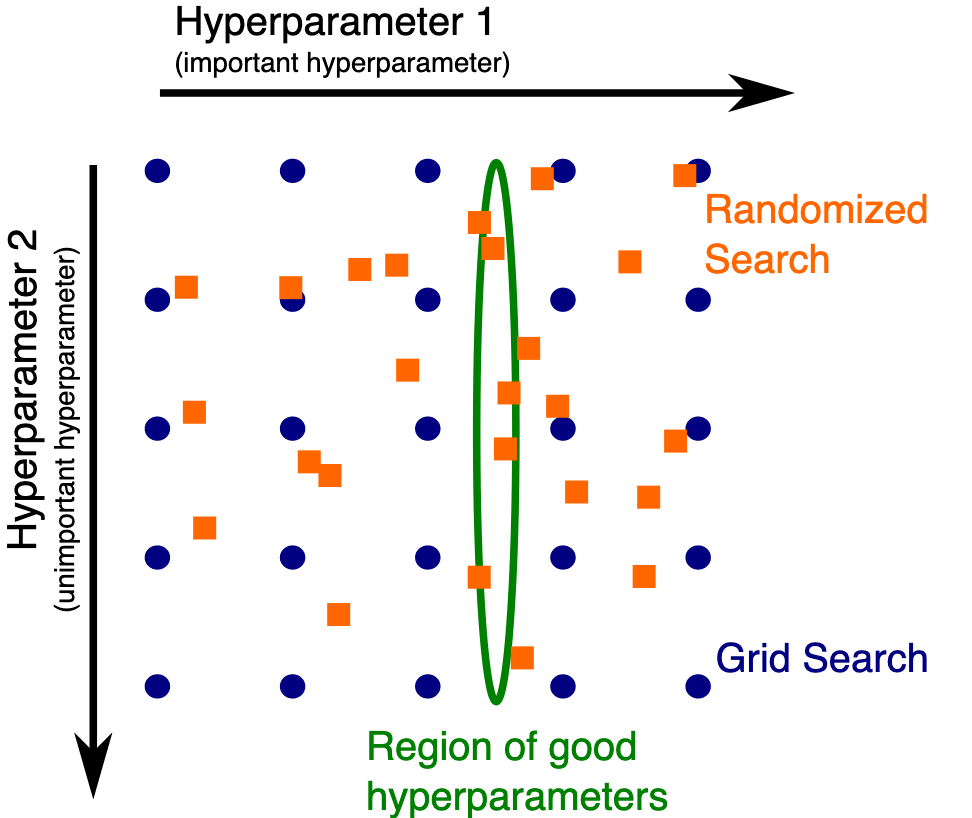

The number of evaluation points need to be divided across the two different hyperparameters. With a grid, the danger is that the region of good hyperparamerters fall between the line of the grid: this region is aligned with the grid given that hyperparameter 2 has a weak influence. Rather, stochastic search will sample hyperparameter 1 independently from hyperparameter 2 and find the optimal region.

Random search (with `RandomizedSearchCV`) is typically beneficial compared to grid search (with `GridSearchCV`) to optimize 3 or more hyperparameters.

We will optimize 3 other parameters in addition to the ones we optimized in the notebook presenting the `GridSearchCV`:

* `L2_regularization`: it corresponds to the constant to regularize the loss function
* `min_samples_leaf`: it corresponds to the minimum number of samples required in a leaf;
* `max_bins`: it corresponds to the maximum number of bins to construct the histograms.

We recall the meaning of the 2 remaining parameters:

* `Learning_rate`: it corresponds to the speed at which the gradient-boosting will correct the residuals at each boosting iteration; 
* `max_leaf_nodes`: it corresponds to the maximum number of leaves for each tree in the ensemble.

<div class="alert alert-block alert-info">
    <b>Tip:</b><em> scipy.stats.loguniform</em> can be used to generate floating numbers.</div>

In [10]:
from scipy.stats import loguniform

class loguniform_int:
    """Integer valued version of the log-uniform distribution"""
    def __init__(self, a, b):
        self._distribution = loguniform(a, b)
        
    def rvs(self, *args, **kwargs):
        """Random variable sample"""
        return self._distribution.rvs(*args, **kwargs).astype(int)

Now, we can define the randomized search using the different distributions: 10 iterations of 5-fold cross validation for random parameters.

In [11]:
%%time
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'classifier__l2_regularization': loguniform(1e-6, 1e3),
    'classifier__learning_rate': loguniform(0.001, 10),
    'classifier__max_leaf_nodes': loguniform_int(2, 256),
    'classifier__min_samples_leaf': loguniform_int(1, 100),
    'classifier__max_bins': loguniform_int(2, 255),
}

model_random_search = RandomizedSearchCV(
    model, param_distributions=param_distributions, n_iter=10,
    cv=5, verbose=1,
)
model_random_search.fit(data_train, target_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 2min 44s, sys: 5.87 s, total: 2min 49s
Wall time: 50.9 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                sparse_threshold=0,
                                                                transformers=[('cat-preprocessor',
                                                                               OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                              unknown_value=-1),
                                                                               ['workclass',
                                                                                'education',
                                                                                'marital-status',
                                                                                'occupation',
                                                                                'relationship',
                                                                                'race',
                                                                                'sex',
                                                                                'native-country'])])),
                                             ('classifier',
                                              Hi...
                   param_distributions={'classifier__l2_regularization': <scipy.stats._distn_infrastructure.rv_frozen object at 0x143eed5b0>,
                                        'classifier__learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x143edfe50>,
                                        'classifier__max_bins': <__main__.loguniform_int object at 0x143ece820>,
                                        'classifier__max_leaf_nodes': <__main__.loguniform_int object at 0x143eed340>,
                                        'classifier__min_samples_leaf': <__main__.loguniform_int object at 0x143ef32e0>},
                   verbose=1)

Then, we can compute the accuracy score on the test set.

In [12]:
accuracy = model_random_search.score(data_test, target_test)
print(f"The test accuracy score of the best model is "
      f"{accuracy:.2f}")

The test accuracy score of the best model is 0.87


In [13]:
from pprint import pprint

print("The best parameters are:")
pprint(model_random_search.best_params_)

The best parameters are:
{'classifier__l2_regularization': 761.737160141496,
 'classifier__learning_rate': 0.7259561419490361,
 'classifier__max_bins': 120,
 'classifier__max_leaf_nodes': 5,
 'classifier__min_samples_leaf': 98}


We can inspect the results using the attributes `cv_results` as we did previously.

In [14]:
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name

In [15]:
# get the parameter names
column_results = [
    f"param_{name}" for name in param_distributions.keys()]
column_results += [
    "mean_test_score", "std_test_score", "rank_test_score"]

cv_results = pd.DataFrame(model_random_search.cv_results_)
cv_results = cv_results[column_results].sort_values(
    "mean_test_score", ascending=False)
cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,l2_regularization,learning_rate,max_leaf_nodes,min_samples_leaf,max_bins,mean_test_score,std_test_score,rank_test_score
7,761.73716,0.725956,5,98,120,0.860173,0.003120,1
4,920.969934,0.055284,62,46,200,0.852638,0.001705,2
6,0.890515,0.889164,5,5,22,0.851301,0.002284,3
9,0.117744,0.010148,16,38,3,0.794163,0.001664,4
3,0.000018,0.001495,108,14,12,0.758947,0.000013,5
5,21.544064,0.006042,44,26,3,0.758947,0.000013,5
8,0.001099,0.002209,79,35,3,0.758947,0.000013,5
2,0.777961,3.950701,3,26,145,0.714067,0.007474,8
1,0.03353,3.157126,16,5,38,0.704432,0.037709,9
0,0.001123,2.48228,7,7,24,0.619362,0.129409,10


In practice, a randomized hyperparameter search is usually run with a large number of iterations.